In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow import keras

# Problem 1

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [26]:
x_train=x_train.reshape(x_train.shape[0],-1).T

In [27]:
x_train.shape

(784, 60000)

In [28]:
mu=x_train.mean(axis=1).reshape(784,1)

In [29]:
centered_ims=x_train-mu

In [30]:
covariance_mat=np.cov(centered_ims)

In [31]:
evals, evecs = np.linalg.eig(covariance_mat)

In [32]:
evecs=evecs/np.linalg.norm(evecs,axis=0)
evals=evals[np.flip(np.argsort(evals))]
evecs=evecs[:,np.flip(np.argsort(evals))]

Text(0.5, 0.98, 'Scree graph for first 200 Eigenvalues')

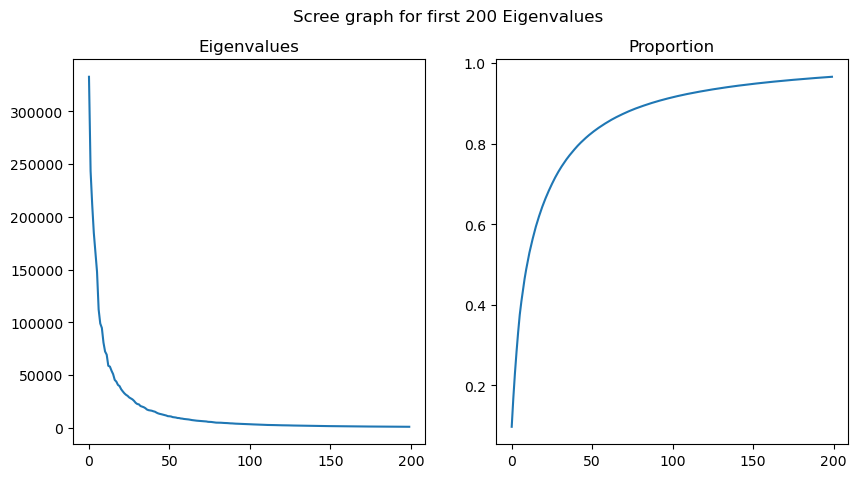

In [33]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(0,200),evals[:200])
axes[0].set_title("Eigenvalues")
proportion=evals.cumsum()/sum(evals)
axes[1].plot(range(0,200),proportion[:200])
axes[1].set_title("Proportion")
fig.suptitle("Scree graph for first 200 Eigenvalues")

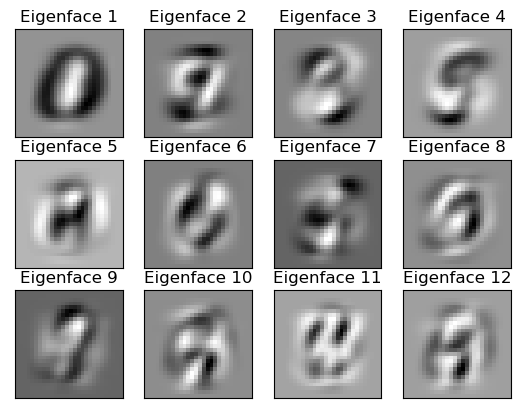

In [34]:
fig,axes=plt.subplots(3,4)
for i in range(3):
    for j in range(4):
        axes[i,j].imshow(evecs[:,4*i+j].reshape((28,28)),cmap="gray")
        axes[i,j].set_title(f"Eigenface {4*i+j+1}")
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])

In [12]:
class Node:
    def __init__(self,points,point_indices=None,depth=0,axisMedian=None,axis:int=None,left=None,right=None):
        self.points=points
        self.point_indices=[]
        self.depth=depth
        # self.nodeType=nodeType
        self.axis=axis
        self.axisMedian=axisMedian
        self.left=left
        self.right=right
    

In [13]:
class KDTree:
    def __init__(self,points,maxDepth,minPoints):
        self.maxDepth=maxDepth
        self.minPoints=minPoints
        self.root=self.kdtree(points,0,maxDepth,minPoints)
        self.leaf_nodes=[]
        
    def kdtree(self,points,depth,maxDepth,minPoints):
        if (depth==maxDepth+1) or (points.shape[1]<minPoints):
            return
        d=points.shape[0]
        axis=np.argmax(np.var(points,axis=1))
        axis_median=np.median(points[axis,:])
        points_left=points[:,points[axis,:]<axis_median]
        points_right=points[:,points[axis,:]>=axis_median]
        return Node(points=points,depth=depth,axisMedian=axis_median,axis=axis,
             left=self.kdtree(points_left,depth+1,maxDepth,minPoints),
             right=self.kdtree(points_right,depth+1,maxDepth,minPoints))
    
    def search_kdtree(self,node,point):
        if (node.left==None and node.right==None) or (node.depth==self.maxDepth) or (node.points.shape[1] < self.minPoints):
            return node
        if point[node.axis][0]<node.axisMedian:
            return self.search_kdtree(node.left,point)
        else:
            return self.search_kdtree(node.right,point)
    def find_leaf_nodes(self,node):
        if (node.left==None and node.right==None) or (node.depth==self.maxDepth) or (node.points.shape[1] < self.minPoints):
            self.leaf_nodes.append(node)
            return
        self.find_leaf_nodes(node.left)
        self.find_leaf_nodes(node.right)
        

In [99]:
def hash_generate(tree,node,point):
    if (node.left==None and node.right==None) or (node.depth==tree.maxDepth) or (node.points.shape[1] < tree.minPoints):
            return ""
    if point[node.axis][0]<node.axisMedian:
            return "0"+hash_generate(tree,node.left,point)
    else:
            return "1"+hash_generate(tree,node.right,point)

hash_generate(tree1,tree1.root,point)

In [14]:
def precision(actual,predicted):
    count=0
    for i in range(len(predicted)):
        if predicted[i]==actual:
            count+=1
    return count/len(predicted)

In [90]:
x_test_reshaped=x_test.reshape(x_test.shape[0],-1).T
cent_test=x_test_reshaped-mu
inds=[]
for i in range(10):
    inds.append(np.random.choice(np.where(y_test==i)[0]))
inds=np.array(inds)
samples=x_test_reshaped[:,inds].reshape(784,-1)

## d = 20, depth_max = 5, m=400

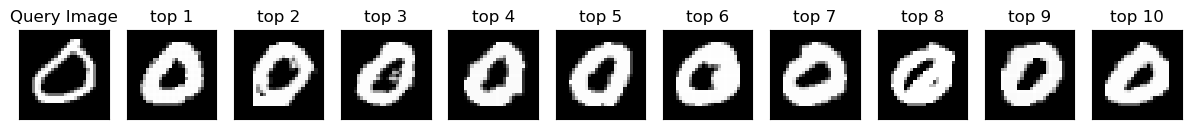

Precision for given image is  1.0


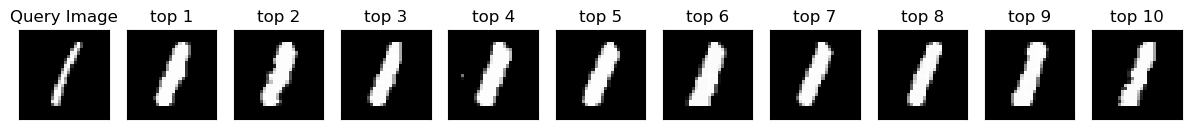

Precision for given image is  1.0


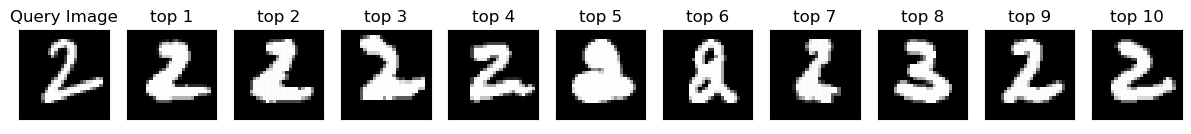

Precision for given image is  0.9


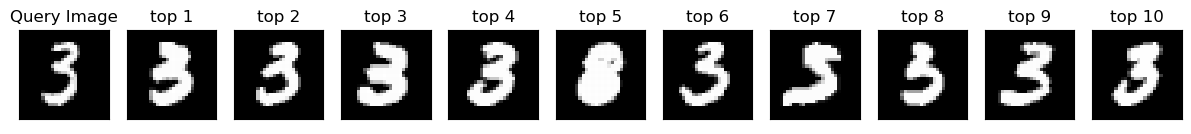

Precision for given image is  0.8


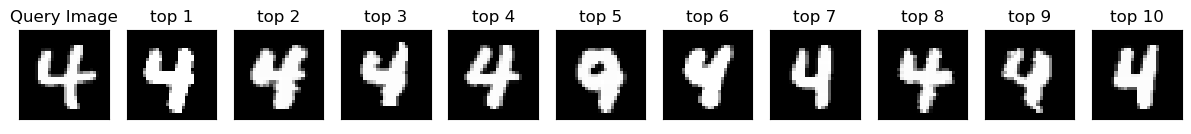

Precision for given image is  0.9


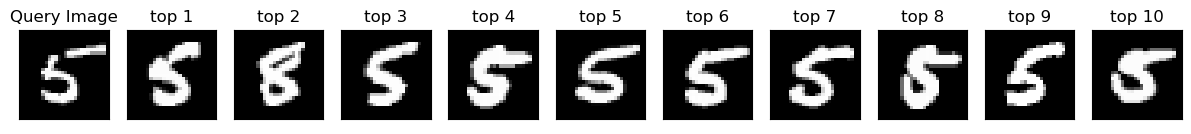

Precision for given image is  0.9


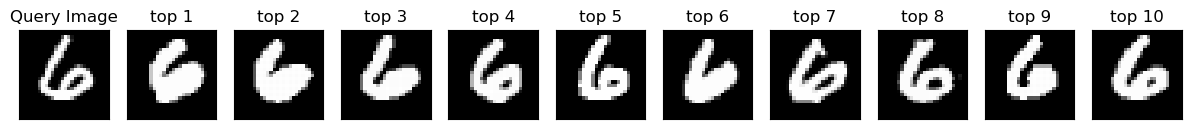

Precision for given image is  1.0


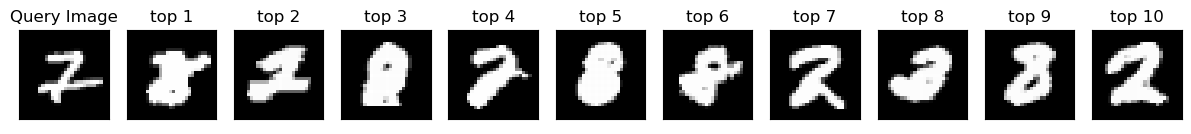

Precision for given image is  0.0


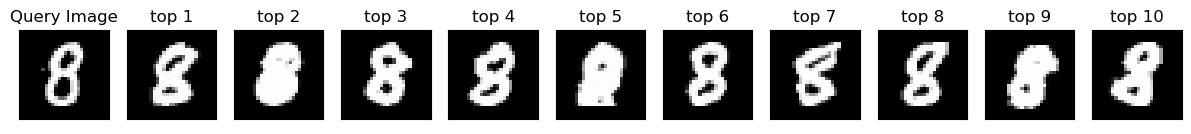

Precision for given image is  1.0


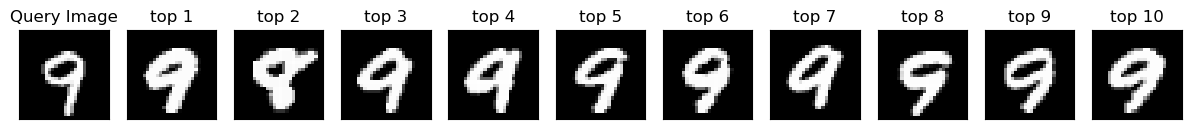

Precision for given image is  0.9
Average Precision : 0.8400000000000001


In [91]:
Q=evecs[:,:20]
points=np.dot(Q.T,centered_ims)
tree=KDTree(points,5,400)
tree.find_leaf_nodes(tree.root)
for i in range(points.shape[1]):
    node=tree.search_kdtree(tree.root,points[:,i].reshape(len(points[:,i]),-1))
    node.point_indices.append(i)
average_precision=[]
for i in range(samples.shape[1]):
    fig,axes=plt.subplots(1,11,figsize=(15,20))
    sample=np.dot(Q.T,samples[:,i])
    sample=sample.reshape(sample.shape[0],-1)
    axes[0].imshow(samples[:,i].reshape(28,28),cmap='gray')
    axes[0].set_xticks([]) 
    axes[0].set_yticks([])
    axes[0].set_title("Query Image")
    region=tree.search_kdtree(tree.root,sample)
    similar_points=region.points
    norms=np.linalg.norm(similar_points-sample,axis=0)
    top_10_ind=np.array(region.point_indices)[np.argsort(norms)][:10]
    top_10=x_train[:,top_10_ind]
    for j in range(10):
        axes[j+1].imshow(top_10[:,j].reshape(28,28),cmap='gray')
        axes[j+1].set_xticks([]) 
        axes[j+1].set_yticks([])
        axes[j+1].set_title(f"top {j+1}")
    plt.show()
    print(f"Precision for given image is ",precision(y_test[inds[i]],y_train[top_10_ind]))
    average_precision.append(precision(y_test[inds[i]],y_train[top_10_ind]))
print(f"Average Precision : {sum(average_precision)/len(average_precision)}")

## d = 5, depth_max = 100, m=60

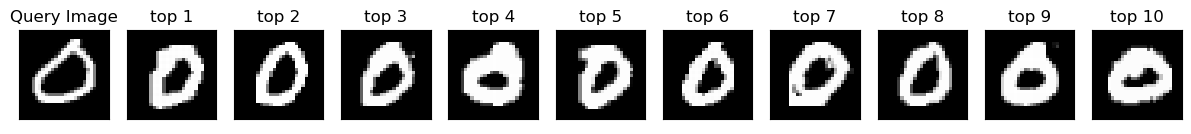

Precision for given image is  1.0


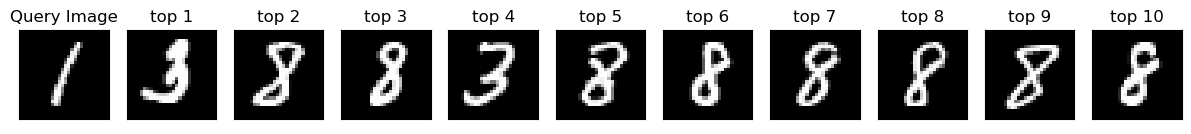

Precision for given image is  0.0


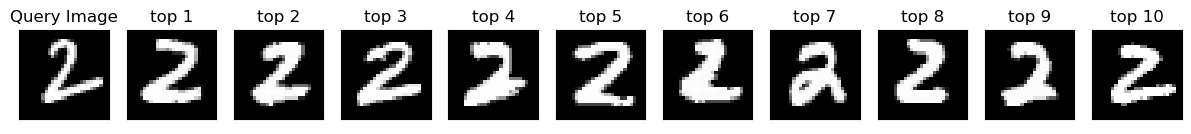

Precision for given image is  1.0


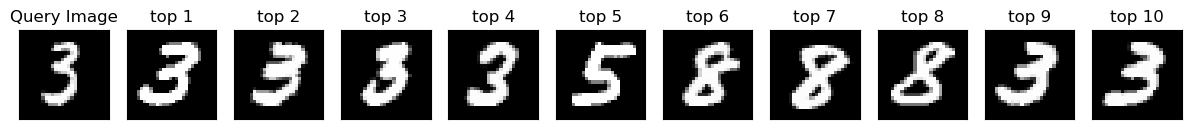

Precision for given image is  0.6


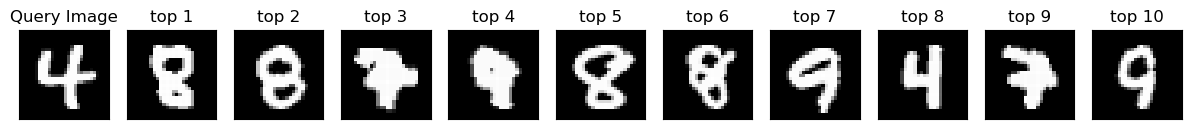

Precision for given image is  0.1


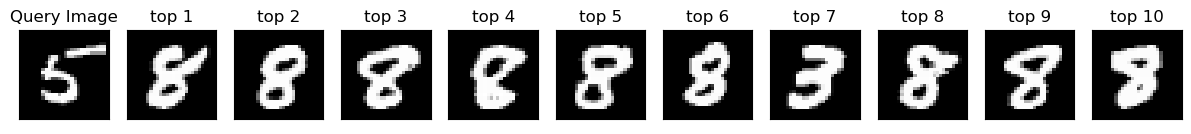

Precision for given image is  0.0


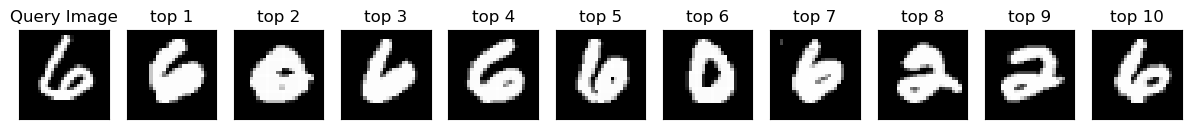

Precision for given image is  0.6


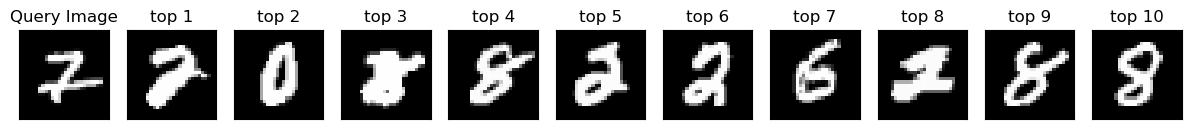

Precision for given image is  0.0


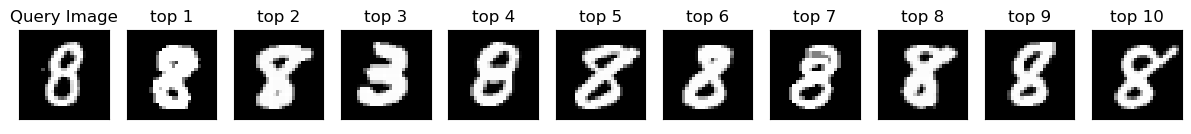

Precision for given image is  0.9


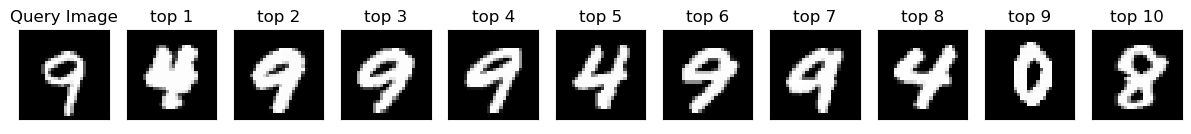

Precision for given image is  0.5
Average Precision : 0.47000000000000003


In [92]:
Q=evecs[:,:5]
points=np.dot(Q.T,centered_ims)
tree=KDTree(points,100,60)
tree.find_leaf_nodes(tree.root)
for i in range(points.shape[1]):
    node=tree.search_kdtree(tree.root,points[:,i].reshape(len(points[:,i]),-1))
    node.point_indices.append(i)
average_precision=[]
for i in range(samples.shape[1]):
    fig,axes=plt.subplots(1,11,figsize=(15,20))
    sample=np.dot(Q.T,samples[:,i])
    sample=sample.reshape(sample.shape[0],-1)
    axes[0].imshow(samples[:,i].reshape(28,28),cmap='gray')
    axes[0].set_xticks([]) 
    axes[0].set_yticks([])
    axes[0].set_title("Query Image")
    region=tree.search_kdtree(tree.root,sample)
    similar_points=region.points
    norms=np.linalg.norm(similar_points-sample,axis=0)
    top_10_ind=np.array(region.point_indices)[np.argsort(norms)][:10]
    top_10=x_train[:,top_10_ind]
    for j in range(10):
        axes[j+1].imshow(top_10[:,j].reshape(28,28),cmap='gray')
        axes[j+1].set_xticks([]) 
        axes[j+1].set_yticks([])
        axes[j+1].set_title(f"top {j+1}")
    plt.show()
    print(f"Precision for given image is ",precision(y_test[inds[i]],y_train[top_10_ind]))
    average_precision.append(precision(y_test[inds[i]],y_train[top_10_ind]))
print(f"Average Precision : {sum(average_precision)/len(average_precision)}")

## d = 50, depth_max = 50, m=50

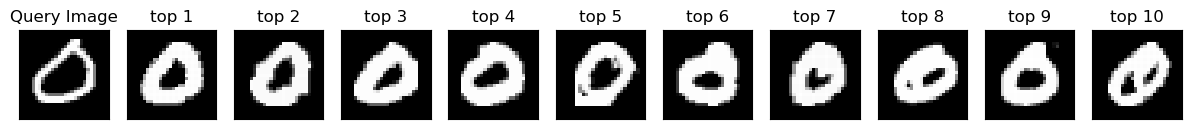

Precision for given image is  1.0


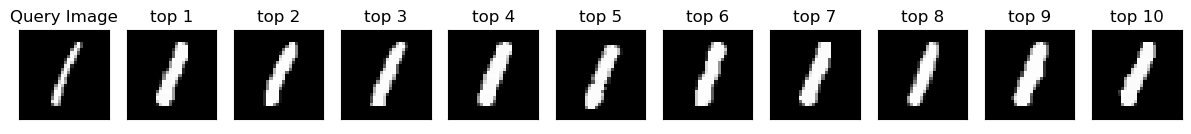

Precision for given image is  1.0


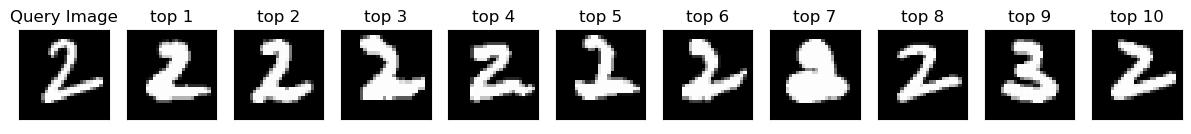

Precision for given image is  0.9


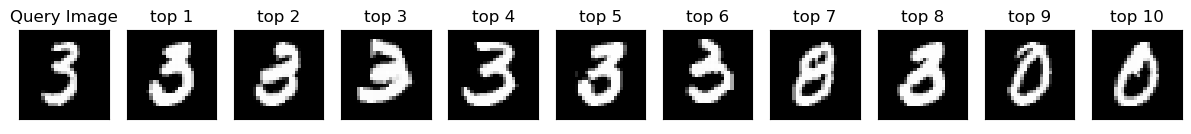

Precision for given image is  0.7


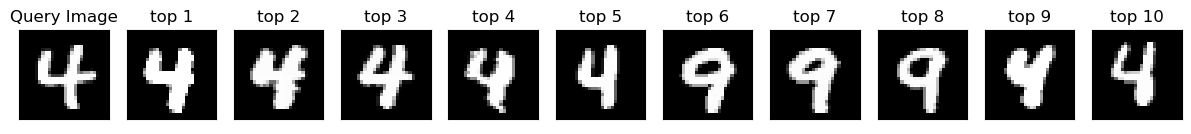

Precision for given image is  0.7


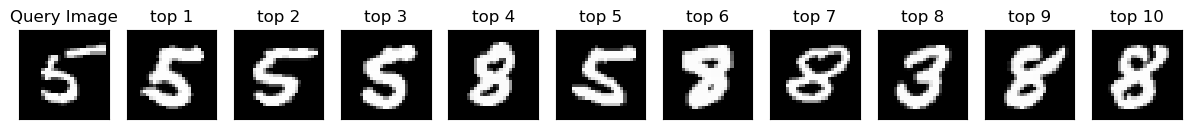

Precision for given image is  0.4


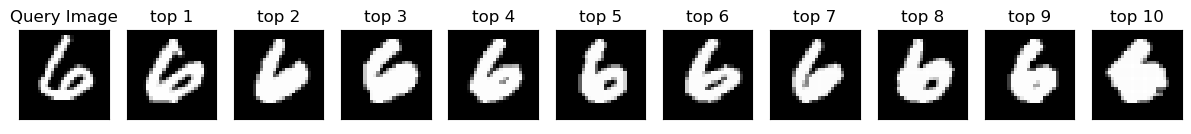

Precision for given image is  1.0


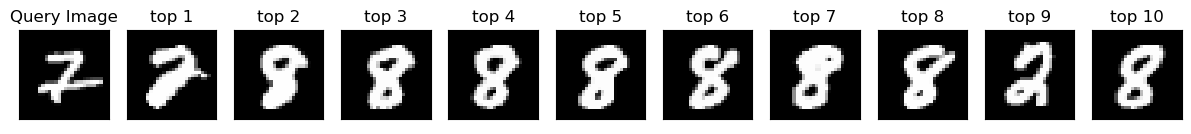

Precision for given image is  0.0


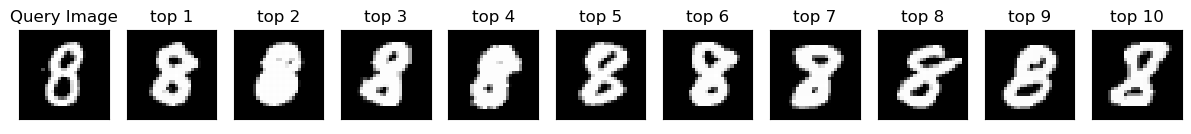

Precision for given image is  1.0


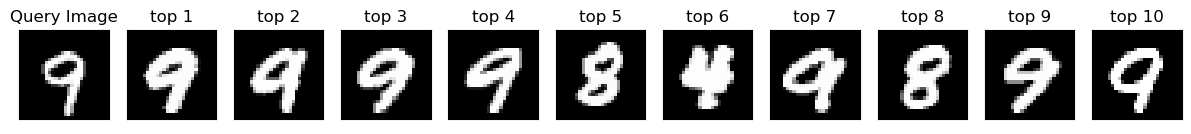

Precision for given image is  0.7
Average Precision : 0.74


In [93]:
Q=evecs[:,:50]
points=np.dot(Q.T,centered_ims)
tree=KDTree(points,50,50)
tree.find_leaf_nodes(tree.root)
for i in range(points.shape[1]):
    node=tree.search_kdtree(tree.root,points[:,i].reshape(len(points[:,i]),-1))
    node.point_indices.append(i)
average_precision=[]
for i in range(samples.shape[1]):
    fig,axes=plt.subplots(1,11,figsize=(15,20))
    sample=np.dot(Q.T,samples[:,i])
    sample=sample.reshape(sample.shape[0],-1)
    axes[0].imshow(samples[:,i].reshape(28,28),cmap='gray')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Query Image")
    region=tree.search_kdtree(tree.root,sample)
    similar_points=region.points
    norms=np.linalg.norm(similar_points-sample,axis=0)
    top_10_ind=np.array(region.point_indices)[np.argsort(norms)][:10]
    top_10=x_train[:,top_10_ind]
    for j in range(10):
        axes[j+1].imshow(top_10[:,j].reshape(28,28),cmap='gray')
        axes[j+1].set_xticks([]) 
        axes[j+1].set_yticks([])
        axes[j+1].set_title(f"top {j+1}")
    plt.show()
    print(f"Precision for given image is ",precision(y_test[inds[i]],y_train[top_10_ind]))
    average_precision.append(precision(y_test[inds[i]],y_train[top_10_ind]))
print(f"Average Precision : {sum(average_precision)/len(average_precision)}")

# Problem 2

In [107]:
path="D:\\Semester 2\\Machine Learning Lab\\6_PCA_on_Yale_face_dataset_and_LDA\\faces"
im_files=os.listdir(path)

In [108]:
im=Image.open(path+"\\"+im_files[0])

im=np.array(im.resize((int(im.size[0]/2),int(im.size[1]/2))))

images=[]
for i in range(0,len(im_files)):
    im=Image.open(path+"\\"+im_files[i])
    im=np.array(im.resize((int(im.size[0]/2),int(im.size[1]/2))))
    images.append(im)
images=np.array(images)
images=images.reshape((images.shape[0], -1))

images=images.astype(float)

In [109]:
image_norms=np.linalg.norm(images,axis=1)
for i in range(len(images)):
    images[i]=images[i]/image_norms[i]

In [110]:
def spherical_k_means(array,k,eps=0.0001,iters=100):
    n=array.shape[0]
    d=array.shape[1]
    L=np.random.randint(0,k,n)
    prev_means=list(np.zeros((k,d)))
    for iteration in range(iters):
        means=np.zeros((k,d))
        count=np.zeros(k)
        for i in range(n):
            ind=L[i]
            count[ind]+=1
            means[ind]+=array[i]
        means=means/count.reshape((k,1))
        means=means/(np.linalg.norm(means,axis=1).reshape((k,1)))
        if min((means*prev_means).sum(axis=1))>1-eps:
            break
        for i in range(n):
            ind=np.argmax(means.dot(array[i]))
            L[i]=ind
        prev_means=means
    return means,L

In [111]:
means,L=spherical_k_means(images,15,0.0001)

In [112]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

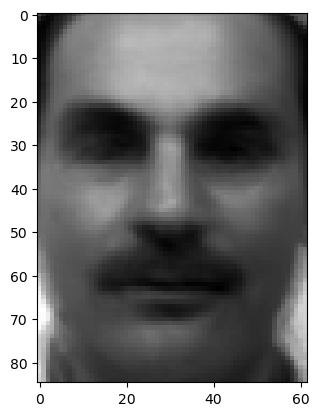

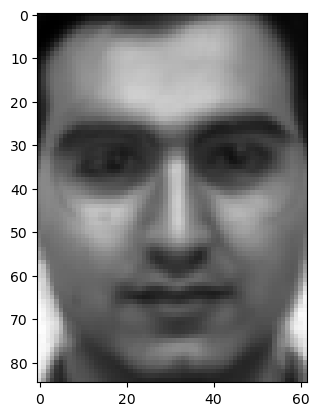

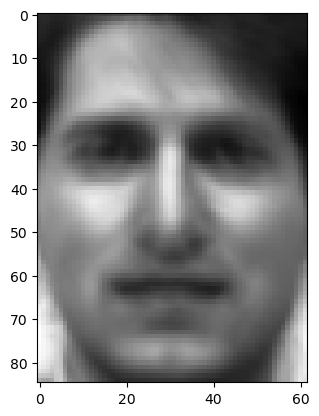

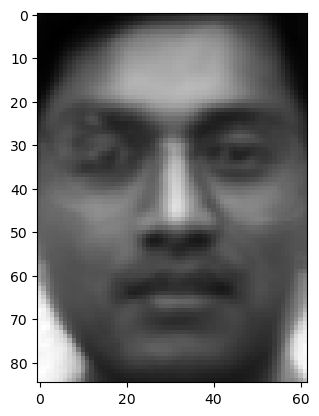

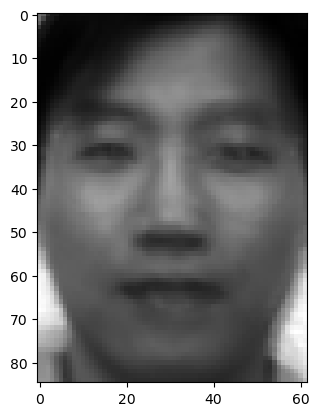

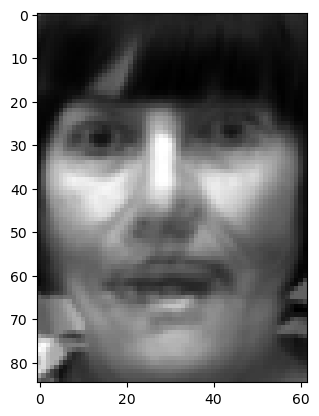

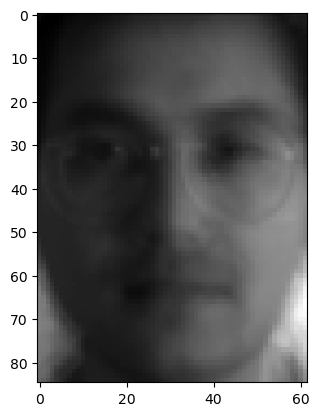

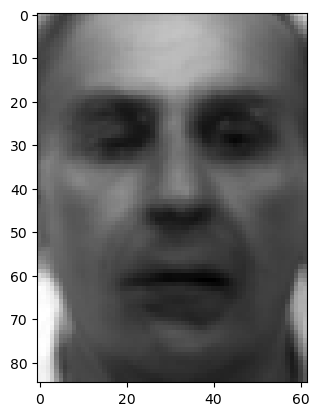

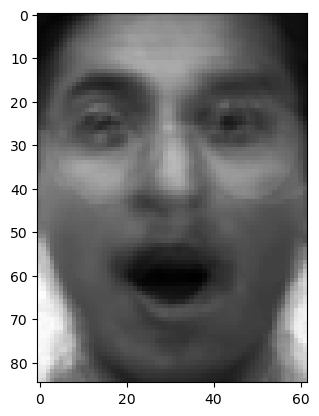

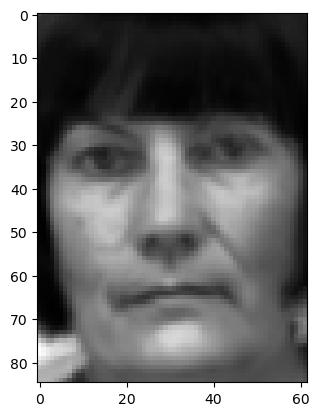

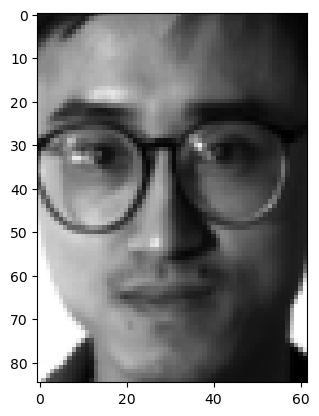

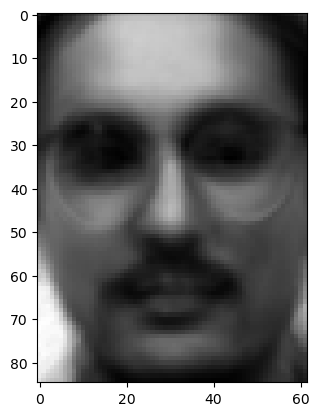

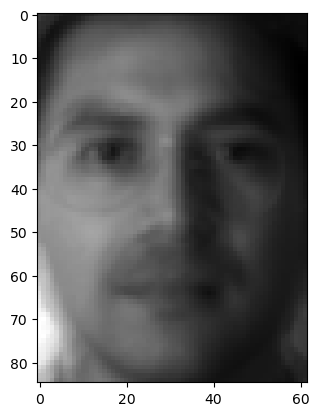

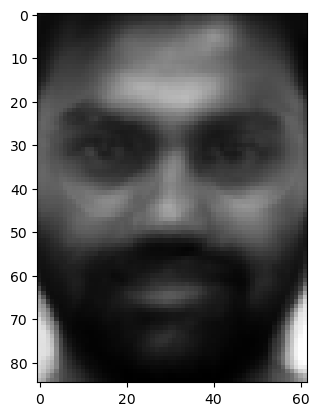

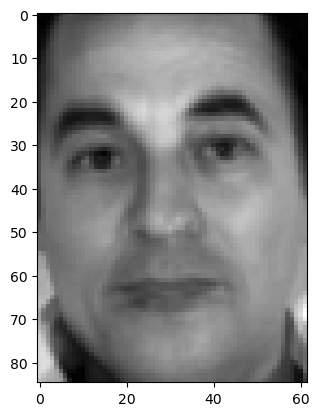

In [113]:
for i in range(len(means)):
    plt.imshow(means[i].reshape(85,62))
    plt.show()

In [114]:
means,L=spherical_k_means(images,5,0.0001)

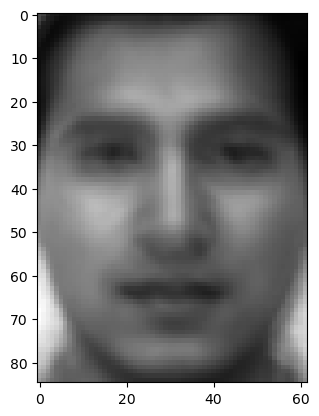

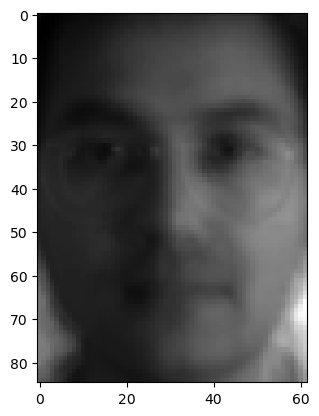

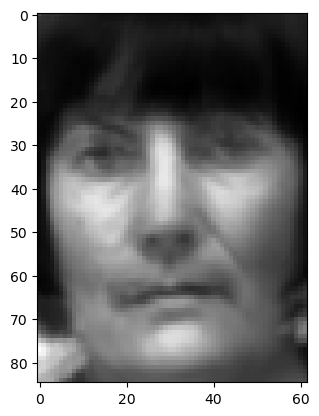

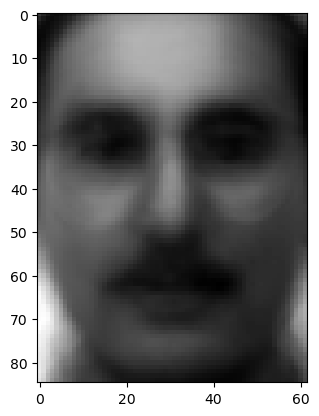

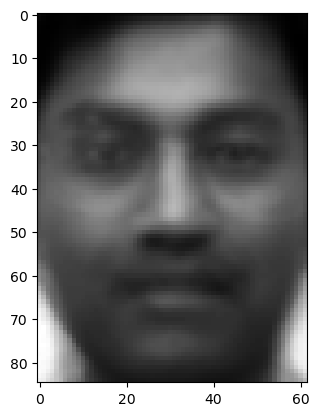

In [115]:
for i in range(len(means)):
    plt.imshow(means[i].reshape(85,62))
    plt.show()